# Install and import packages

In [91]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [93]:
import pandas as pd
import matplotlib.pyplot as plt

import joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from ray import train, tune
from ray.train import Checkpoint
import ray.train.torch
from ray.tune.schedulers import ASHAScheduler


# Custom Dataset class for JUND transcription factor data

In [72]:
class JUND_Dataset(Dataset):
    def __init__(self, data_dir):
        """Loads X, y, w, a from data_dir."""
        super().__init__()
        
        # load X, y, w, a from data_dir
        X = joblib.load(f"{data_dir}/shard-0-X.joblib")
        y = joblib.load(f"{data_dir}/shard-0-y.joblib")
        w = joblib.load(f"{data_dir}/shard-0-w.joblib")
        a = joblib.load(f"{data_dir}/shard-0-a.joblib")
        
        # convert them into torch tensors
        self.X = torch.tensor(data=X, dtype=torch.float32)
        self.y = torch.tensor(data=y, dtype=torch.int8)
        self.w = torch.tensor(data=w, dtype=torch.float32)
        self.a = torch.tensor(data=a, dtype=torch.float32)
        
    def __len__(self):
        """Returns length of dataset."""
        return self.X.size(dim=0)
        
    def __getitem__(self, idx):
        """Returns X, y, w, a values at index idx."""
        return self.X[idx], self.y[idx], self.w[idx], self.a[idx]

# MLP Model

In [74]:
class MLP(nn.Module):
    def __init__(self, hidden_layer_size: int):
        """Initializes a multi-layer perceptron model.
        
        Args:
            hidden_layer_size (int): Size of hidden layer.
        """
        super().__init__()
        
        # one batch of samples has dimensions [B, 101, 4]
        # where B is the number of samples in the batch
        self.flatten = nn.Flatten(start_dim=1)
        self.hidden_layer = nn.Linear(in_features=404, out_features=hidden_layer_size)
        self.output_layer = nn.Linear(in_features=hidden_layer_size + 1, out_features=1)
    
    def forward(self, x_batch: torch.Tensor, a_batch: torch.Tensor):
        """Performs forward pass with a batch of data.
        
        Args:
            x_batch (torch.Tensor): Batch of Chr22 segments. Tensor size [B, 101, 4]
            a_batch (torch.Tensor): Batch of accessibility values per segment. Tensor size [B, 1]
        
        """
        x = self.flatten(x_batch)  # x now has size [B, 404]
        
        x = self.hidden_layer(x)  # [B, hidden_layer_size]
        x = F.relu(x)
        x = F.dropout(input=x, p=0.3)
        
        x = torch.cat((x, a_batch), dim=1)  # [B, hidden_layer_size + 1]
        
        x = self.output_layer(x)  # [B, 1]
        
        return x

# Define training and validation data loading function

In [61]:
def get_datasets(
    train_dir="./data/JUND/train", 
    val_dir="./data/JUND/validation", 
):
    """Returns training and validation Dataset objects.
    
    Args:
        train_dir (str): Path to training data directory.
        val_dir (str): Path to validation data directory.    
    """
    trainset = JUND_Dataset(data_dir=train_dir)
    valset = JUND_Dataset(data_dir=val_dir)

    return trainset, valset

# Define training and evaluation functions

In [88]:
def train_func(
    model,
    device,
    optimizer,
    data_loader,
):
    """Performs 1 epoch of training by mini-batch.
    """
    model.train()
    for batch_idx, data in enumerate(data_loader):
        # get the inputs; data is a list of [X, y, w, a]
        X, y, w, a = data
        X, y, w, a = X.to(device), y.to(device), w.to(device), a.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        model_output = model(x_batch=X, a_batch=a)
        loss = F.binary_cross_entropy_with_logits(
            input=model_output, 
            target=y.to(torch.float32),
            weight=w,
        )
        loss.backward()
        optimizer.step()
    
def eval_func(
    model,
    device,
    data_loader,
):
    """Performs 1 epoch of evaluation on validation data by mini-batch.
    """
    model.eval()
    total_weight = 0.
    correct_weight = 0.
    with torch.no_grad():
        for data in data_loader:
            # get the inputs; data is a list of [X, y, w, a]
            X, y, w, a = data
            X, y, w, a = X.to(device), y.to(device), w.to(device), a.to(device)
            
            model_output = model(x_batch=X, a_batch=a)
            
            y_pred = F.sigmoid(model_output).round()
            
            total_weight += torch.sum(w)
            correct_weight += torch.sum(w * (torch.eq(input=y, other=y_pred)))
    
    acc = correct_weight / total_weight
    return acc.item()

def objective_func(
    config, 
    train_dir="./data/JUND/train", 
    val_dir="./data/JUND/validation", 
):
    """Performs epochs of model training and validation.
    """
    model = MLP(
        hidden_layer_size=config["hidden_layer_size"],
    )
    
    device = "cuda:0" if torch.cuda.is_available() else "cpu" 
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        
    model.to(device)

    optimizer = optim.Adam(params=model.parameters(), lr=config["lr"],)

    trainset, valset = get_datasets(train_dir=train_dir, val_dir=val_dir) 

    trainloader = DataLoader(
        dataset=trainset, 
        batch_size=int(config["batch_size"]), 
        shuffle=True,
        num_workers=2,
    )
                                        
    valloader = DataLoader(
        dataset=valset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=2,
    )
    
    metrics = []
    for epoch in range(config["max_epochs"]):  # loop over the dataset multiple times
        train_func(
            model=model,
            device=device,
            optimizer=optimizer,
            data_loader=trainloader,
        )
                                        
        acc_epoch = eval_func(
            model=model,
            device=device,
            data_loader=valloader,
        )

        metrics.append({
            "Epoch": epoch + 1,
            "Weighted accuracy": acc_epoch,
        })
        print(f"Epoch {epoch + 1}, Weighted accuracy: {acc_epoch}")
                                        
    return model, metrics


# Model training

In [89]:
config = {
    "hidden_layer_size": 128,
    "lr": 0.01,
    "batch_size": 64,
    "max_epochs": 20,
}

trained_model, training_metrics = objective_func(
    config=config,
)

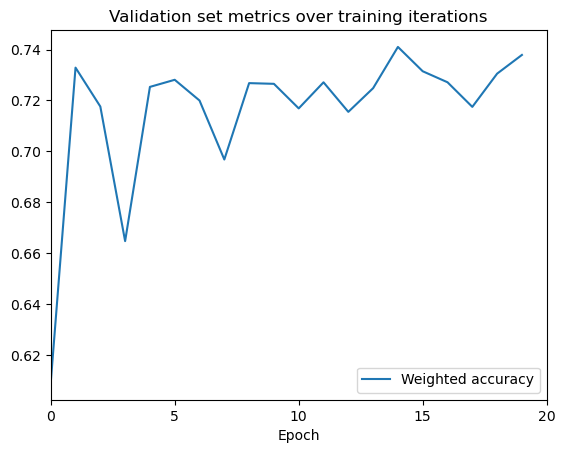

In [126]:
training_metrics = pd.DataFrame(training_metrics)

ax = training_metrics.plot.line(x="Epoch", y="Weighted accuracy")
ax.set(title="Validation set metrics over training iterations")
ax.set_xlim(left=0)
ax.set_xticks(ticks=[*range(0, 20 + 1, 5)])
plt.legend(loc="lower right")
plt.show()

# Define test set evaluation function

In [124]:
def test_best_model(best_model, test_dir="./data/JUND/test"):
    device = "cuda:0" if torch.cuda.is_available() else "cpu" 
    
    if torch.cuda.device_count() > 1:
        best_model = nn.DataParallel(best_model)
        
    best_model.to(device)

    testset = JUND_Dataset(data_dir=test_dir)
    
    testloader = DataLoader(
        testset, 
        batch_size=512, 
        shuffle=False, 
        num_workers=2
    )

    acc = eval_func(
        model=best_model,
        data_loader=testloader,
        device=device,
    )
    
    return acc
    

# Test set accuracy

In [125]:
test_best_model(best_model=trained_model)

0.7316304445266724